In [1]:
import pickle
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from torchvision.datasets import FashionMNIST
import torchvision
from torchvision import transforms
from torch.nn.utils import parameters_to_vector, vector_to_parameters
import os
from tqdm.auto import tqdm

root_path = '../'
import sys
sys.path.insert(-1, root_path)

from src.data import get_transforms
from src.utils import composed_model, compute_likelihood
%matplotlib inline

In [3]:
device = "cuda:0"

In [4]:
transforms_fashionmnist_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.2860, ), (0.3530,)),
])

transforms_fashionmnist_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.2860, ), (0.3530,)),
])

In [5]:
dataset_train = FashionMNIST(os.path.join(root_path, 'data/fashion_mnist'), train=True, download=True,
                                transform=transforms_fashionmnist_train)
dataset_test = FashionMNIST(os.path.join(root_path, 'data/fashion_mnist'), train=False, download=True,
                   transform=transforms_fashionmnist_test,
                  )

In [6]:
torch.std(dataset_train.data / 255.)

tensor(0.3530)

In [7]:
dataset_train.data.shape

torch.Size([60000, 28, 28])

In [8]:
with open(os.path.join(root_path, 'experiment_logs_mnist/0/final_dict.pickle'), 'rb') as file:
    loaded_data = pickle.load(file)

In [9]:
personal_models = loaded_data['personal_models']
shared_model = loaded_data['shared_model']
prior_models = loaded_data['prior_models']
train_loaders = loaded_data['train_loaders']
test_loaders = loaded_data['test_loaders']

In [11]:
ood_dataloader = torch.utils.data.DataLoader(dataset_test, shuffle=False, batch_size=100)

In [12]:
LOG_LIKELIHOOD_FN = lambda x, y: -nn.CrossEntropyLoss(reduction='sum')(x, y)

burn_in = 10
inner_iters = 30

In [13]:
def sample_personal_vec(personal_model, prior_model, shared_model, personal_train_loader, personal_optim):
    samples = torch.tensor([], device=device)
    for m in range(inner_iters):
        log_likelihood_term = compute_likelihood(personal_model=personal_model, dataloader=personal_train_loader,
                           log_likelihood_fn=LOG_LIKELIHOOD_FN, shared_model=shared_model,
                                                 composition_regime='composition', use_sgld=False)
        prior_negative_log_prob = prior_model.get_negative_log_prob(parameters_to_vector(personal_model.model.parameters()))


        personal_model_loss = prior_negative_log_prob - log_likelihood_term
        personal_model_loss.backward()

        personal_optim.step()
        personal_optim.zero_grad()

        if m >= burn_in:
            current_sample = parameters_to_vector(personal_model.model.parameters())[None].detach()
            samples = torch.cat([samples, current_sample])
        
    return samples

def marginal_prediction(samples, personal_model, shared_model, loader):
    with torch.no_grad():
        all_preds = []
        for sample in samples:
            p_preds = torch.tensor([], device=device)
            vector_to_parameters(
                    vec=sample,
                    parameters=personal_model.model.parameters()
                )
            model = composed_model(shared_model, personal_model, "composition")
            for batch in loader:
                x, y = batch
                x = x.to(device)
                y = y.to(device)
                p_pred = torch.softmax(model(x), dim=-1)
                p_preds = torch.cat([p_preds, p_pred])
            all_preds.append(p_preds[None])
    return all_preds

In [14]:
def entropy(p_preds):
    return np.sum(-p_preds * np.log(p_preds), axis=-1)            

In [15]:
def uncertainty_score(dataloader_ind, dataloader_ood, personal_train_loader, personal_model, prior_model, shared_model):
    selected_classes = []
    for batch in personal_train_loader:
        _, y = batch
        selected_classes.append(y.cpu().numpy())
    selected_classes = np.unique(np.hstack(selected_classes))
    for p in personal_model.parameters():
        p.requires_grad_(True)
    scores = [[], []]
    all_p_preds = [[], []]
    loaders = [dataloader_ind, dataloader_ood]
    personal_optim = torch.optim.Adam(personal_model.parameters(), lr=1e-2)
    samples = sample_personal_vec(personal_model=personal_model, prior_model=prior_model, shared_model=shared_model,
                             personal_train_loader=personal_train_loader, personal_optim=personal_optim)
    for p in personal_model.parameters():
        p.requires_grad_(False)
        
    for i in range(len(loaders)):
        all_preds = marginal_prediction(
            samples=samples,
            personal_model=personal_model,
            shared_model=shared_model,
            loader=loaders[i],
        )
        
        concat = torch.cat(all_preds, dim=0)[:, :, selected_classes]
        
        p_preds = torch.mean(concat, dim=0).cpu().numpy()
        he = entropy(p_preds)
        sc = entropy(concat.cpu().numpy())
        eh = np.mean(sc, 0)
        
        res = {
            "EH": eh,
            "HE": he,
            "BALD": he - eh
        }
        
        scores[i].append(res)
        # scores[i].append(he)
        
        concat = torch.cat(all_preds, dim=0)
        p_preds = torch.mean(concat, dim=0).cpu().numpy()
        all_p_preds[i].append(p_preds)
        
    ind_d_scores = {}
    out_d_scores = {}

    for k in ["EH", "HE", "BALD"]:
        ind_d_scores[k] = np.hstack([el[k] for el in scores[0]])
    for k in ["EH", "HE", "BALD"]:
        out_d_scores[k] = np.hstack([el[k] for el in scores[1]])
    
    ind_d_probs = np.hstack(all_p_preds[0])
    out_d_probs = np.hstack(all_p_preds[1])
    
    return ind_d_scores, out_d_scores, ind_d_probs, out_d_probs

In [16]:
def get_uncertainty_scores(shared_model, prior_models, personal_models, train_loaders, test_loaders, ood_loader, n_models):
    model_scores = []
    if n_models == -1:
        n_models = len(personal_models)
    for i in tqdm(range(n_models)):
        ind_d = test_loaders[i]
        ood_d = ood_loader
        train_d = train_loaders[i]
        model_scores.append(
            uncertainty_score(
                dataloader_ind=ind_d,
                dataloader_ood=ood_d,
                personal_train_loader=train_d,
                personal_model=personal_models[i],
                prior_model=prior_models[0],
                shared_model=shared_model
            )
                           )
    return model_scores

In [17]:
scores = get_uncertainty_scores(
    shared_model=shared_model,
    prior_models=prior_models,
    personal_models=personal_models,
    train_loaders=train_loaders,
    test_loaders=test_loaders,
    ood_loader=ood_dataloader,
    n_models=20,
)

  0%|          | 0/20 [00:00<?, ?it/s]

/tmp/ipykernel_4120536/1559823997.py:2: RuntimeWarning: divide by zero encountered in log
  return np.sum(-p_preds * np.log(p_preds), axis=-1)
/tmp/ipykernel_4120536/1559823997.py:2: RuntimeWarning: invalid value encountered in multiply
  return np.sum(-p_preds * np.log(p_preds), axis=-1)


In [23]:
from src.utils import pretty_matplotlib_config
pretty_matplotlib_config(17)

In [24]:
import seaborn as sns

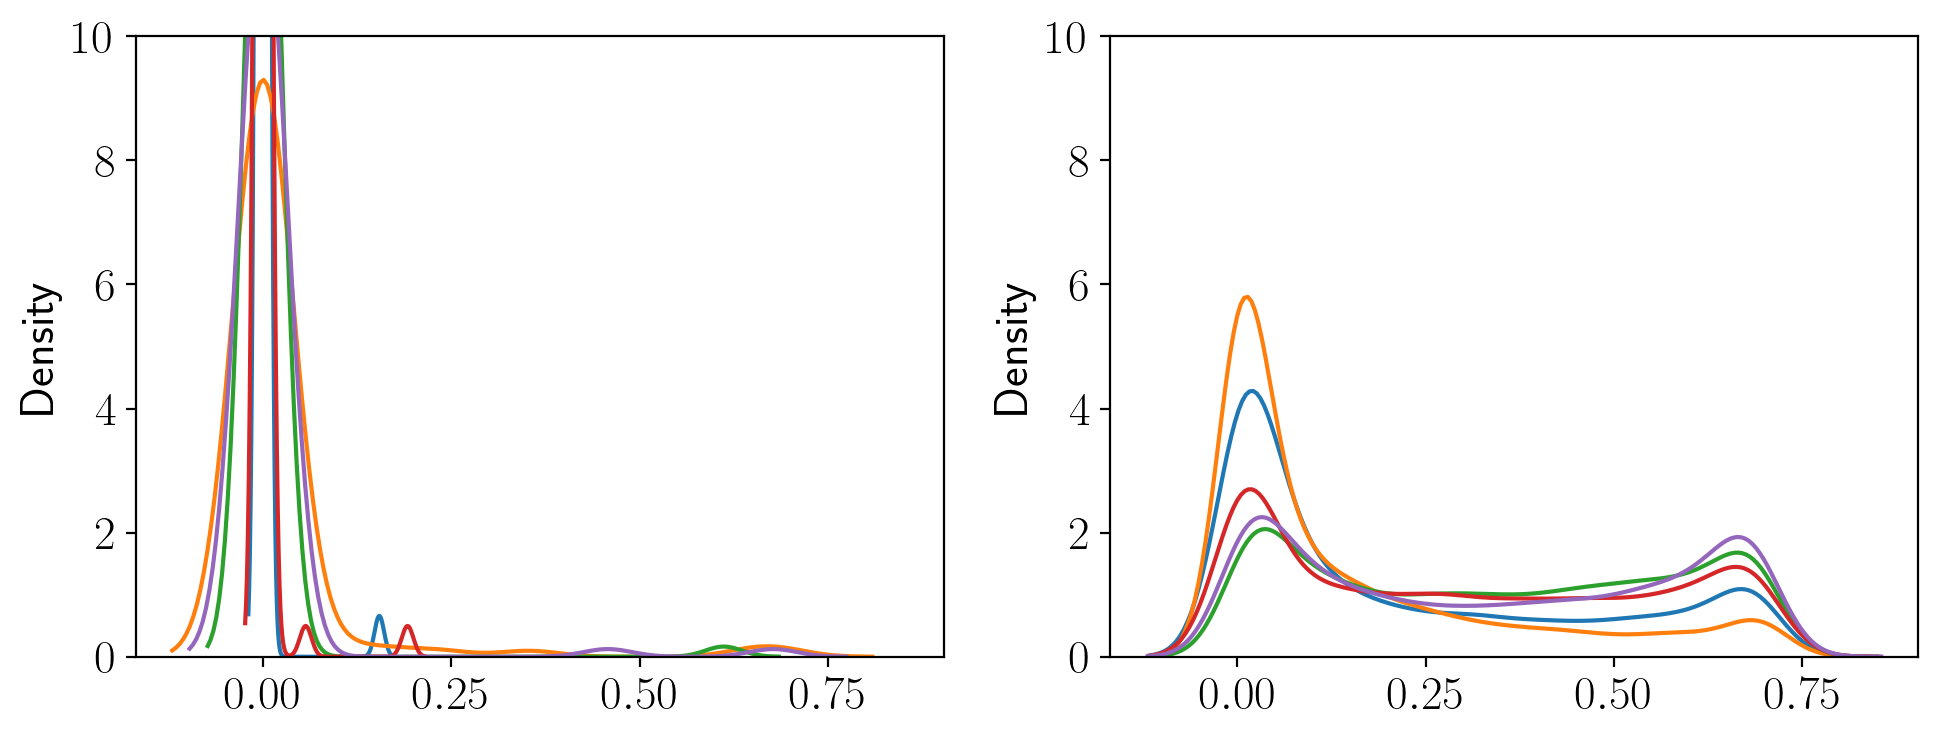

In [29]:
unc_type = "HE"  # "EH", "HE", "BALD"

fig, ax = plt.subplots(ncols=2, dpi=200, figsize=(10, 4), sharex=True)


for i in range(len(scores[:5])):
    ind, ood = scores[i][:2]
    
    ind_p, out_p = scores[i][-2:]
    
    # ax[0].set_xlim(1e-6)
    # ax[0].set_xscale("log")
    # ax[1].set_xscale("log")
    # ax[1].set_xlim(1e-6)
    
    sns.kdeplot(ind[unc_type], ax=ax[0])
    # sns.kdeplot(1 - np.max(ind_p, axis=-1), ax=ax[0])
    ax[0].set_ylim(0, 10)
    sns.kdeplot(ood[unc_type], ax=ax[1])
    # sns.kdeplot(1 - np.max(out_p, axis=-1), ax=ax[1])
    ax[1].set_ylim(0, 10)
# ax[0].set_xlabel("In distribution")
# ax[1].set_xlabel("Out of distribution")
# plt.legend()
plt.tight_layout()
# plt.savefig("./mnist_5_models_uncertainty.pdf", format="pdf")
plt.show();

In [30]:
# trained classes vs untrained

In [31]:
ind_mean_scores = np.vstack([scores[i][0][unc_type][:90][None] for i in range(len(scores))]).mean(0)
ood_mean_scores = np.vstack([scores[i][1][unc_type][None] for i in range(len(scores))]).mean(0)

In [32]:
# sns.set()

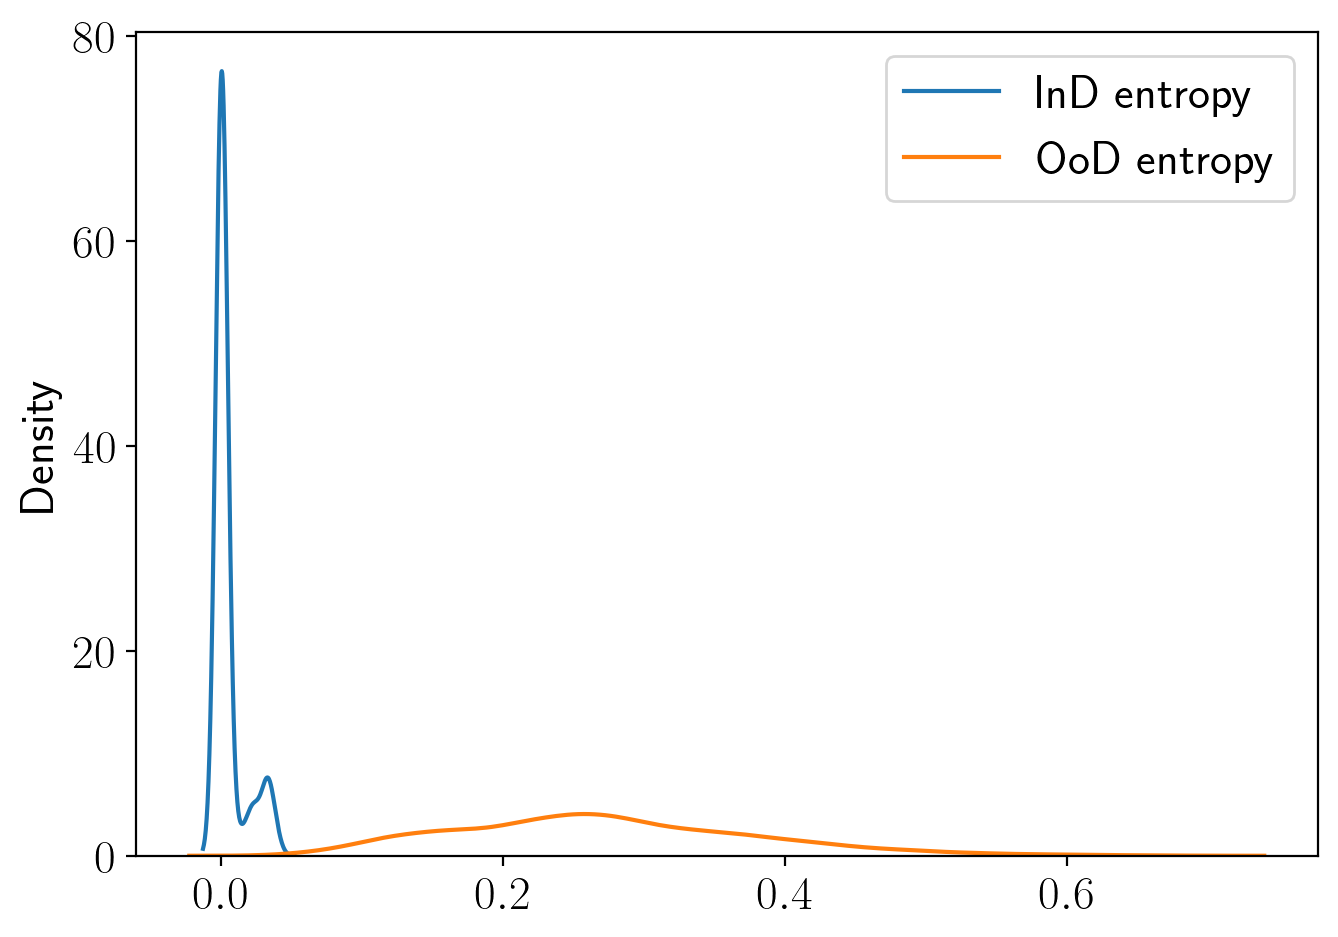

In [33]:
plt.figure(figsize=(7, 5), dpi=200)

sns.kdeplot(ind_mean_scores, label="InD entropy")
sns.kdeplot(ood_mean_scores, label="OoD entropy")

# plt.xlim(left=0)
plt.legend()
plt.tight_layout()
# plt.savefig("./mnist_average_uncertainty.pdf", format="pdf")
plt.show();

In [34]:
from alpaca.utils.datasets.builder import build_dataset
import alpaca.calibrator as calibrator

In [35]:
# Let's build helper function to calculate all the calibration errors
def compute_errors(n_bins, probs, labels, len_dataset, threshold):
    ece = calibrator.compute_ece(n_bins, probs, labels, len_dataset)
    sce = calibrator.compute_sce(n_bins, probs, labels)
    # ace = calibrator.compute_ace(n_bins, probs, labels)
    # tace = calibrator.compute_tace(threshold, probs, labels, n_bins)
    errors = {
        'ece' : ece,
        'sce' : sce,
        # 'ace' : ace,
        # 'tace' : tace
    }
    for name, calibration_error in errors.items():
        print(name, ' = ', calibration_error)

In [52]:
model_index = 0

In [53]:
probs = scores[model_index][2]

In [54]:
probs_ood = scores[model_index][3]

<AxesSubplot:ylabel='Density'>

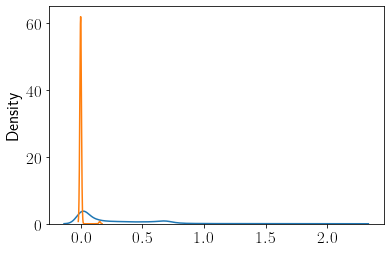

In [55]:
sns.kdeplot(entropy(probs_ood))
sns.kdeplot(entropy(probs))

In [56]:
y_true = []
for batch in test_loaders[model_index]:
    _, y = batch
    y_true.append(y)

In [57]:
val_labels = y_true[0].reshape(-1).cpu().numpy()

In [58]:
compute_errors(n_bins=2, probs=probs, labels=val_labels.reshape(-1, 1),
               len_dataset=np.shape(probs)[0], threshold=0.9)

ece  =  tensor([0.0101])
sce  =  tensor([0.0010])


In [59]:
sys.path.insert(0, '../federated_learning/')

In [60]:
from reliability_diagrams.reliability_diagrams import reliability_diagram

In [65]:
# # UNCOMMENT THIS TO PLOT RELIABILITY DIAG!
# reliability_diagram(
#     true_labels=y_true[0].cpu().numpy().reshape(-1),
#     pred_labels=np.argmax(probs, axis=-1),
#     confidences=np.max(probs, axis=-1),
#     num_bins=10,
# )

In [62]:
y_true[0].cpu().numpy().reshape(-1).shape

(95,)

In [63]:
np.argmax(probs, axis=-1).shape

(95,)

In [64]:
np.mean(np.argmax(probs, axis=-1) == y_true[0].cpu().numpy().reshape(-1))

0.9894736842105263